In [3]:
pip install paretoset

In [50]:
import random
import os
import io
import math
from paretoset import paretoset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [12]:
def calculate_distance(customer1, customer2):
    return math.sqrt((customer1['coord']['x'] - customer2['coord']['x'])**2 + (customer1['coord']['y'] - customer2['coord']['y'])**2)

In [13]:
def preprocesamiento(file):
    text_file = f'data/text/{file}.txt'
    data = {}
    with io.open(text_file, 'rt', encoding='utf-8', newline='') as file_object:
        for line_count, line in enumerate(file_object, start=1):
            if line_count in [1, 3, 5]:
                pass
            elif line_count == 2:
                values = line.strip().split()
                data['customers'] = int(values[0])
            elif line_count == 4:
                values = line.strip().split()
                data['vehicle_capacity'] = float(values[0])
            elif line_count == 6:
                values = line.strip().split()
                data['origin'] = {
                    'coord': {
                        'x': float(values[1]),
                        'y': float(values[2]),
                    },
                    'demand': float(values[3]),
                    'ready_time': float(values[4]),
                    'due_time': float(values[5]),
                    'service_time': float(values[6]),
                }
            else:
                values = line.strip().split()
                data[f'cust_{values[0]}'] = {
                    'coord': {
                        'x': float(values[1]),
                        'y': float(values[2]),
                    },
                    'demand': float(values[3]),
                    'ready_time': float(values[4]),
                    'due_time': float(values[5]),
                    'service_time': float(values[6]),
                }
    customers = ['origin'] + [f'cust_{x}' for x in range(1, 101)]
    data['distance_matrix'] = [[calculate_distance(data[customer1], data[customer2]) for customer1 in customers] for customer2 in customers]
    return data

In [14]:
def ind2route(individuo, instancia):
    ruta = []
    sub_ruta = []
    capacidad = instancia['vehicle_capacity']
    tiempo_limite = instancia['origin']['due_time']
    carga_vehiculo = 0
    tiempo_transcurrido = 0
    ultimo_cust_id = 0
    for cust_id in individuo:
        demanda = instancia[f'cust_{cust_id}']['demand']
        carga_vehiculo_actualizada = carga_vehiculo + demanda
        tiempo_servicio = instancia[f'cust_{cust_id}']['service_time']
        tiempo_regreso = instancia['distance_matrix'][cust_id][0]
        tiempo_transcurrido_actualizado = tiempo_transcurrido + instancia['distance_matrix'][ultimo_cust_id][cust_id] + tiempo_servicio + tiempo_regreso
        if (carga_vehiculo_actualizada <= capacidad) and (tiempo_transcurrido_actualizado <= tiempo_limite):
            sub_ruta.append(cust_id)
            carga_vehiculo = carga_vehiculo_actualizada
            tiempo_transcurrido = tiempo_transcurrido_actualizado - tiempo_regreso
        else:
            ruta.append(sub_ruta)
            sub_ruta = [cust_id]
            carga_vehiculo = demanda
            tiempo_transcurrido = instancia['distance_matrix'][0][cust_id] + tiempo_servicio
        ultimo_cust_id = cust_id
    if sub_ruta != []:
        ruta.append(sub_ruta)
    return ruta

In [230]:
def evaluacion(individuo, instancia):
    evaluacion = {}
    costo_total = 0
    cantidad_vehiculo = 0
    ruta = ind2route(individuo, instancia)
    for sub_ruta in ruta:
        cantidad_vehiculo += 1
        tiempo_subruta = 0
        distancia_subruta = 0
        tiempo_transcurrido = 0
        ultimo_cust_id = 0
        for cust_id in sub_ruta:
            distancia = instancia['distance_matrix'][ultimo_cust_id][cust_id]
            distancia_subruta += distancia
            tiempo_llegada = tiempo_transcurrido + distancia
            costo_tiempo = max(instancia[f'cust_{cust_id}']['ready_time'] - tiempo_llegada, 0) + max(tiempo_llegada - instancia[f'cust_{cust_id}']['due_time'], 0)
            tiempo_subruta += costo_tiempo
            tiempo_transcurrido = tiempo_llegada + instancia[f'cust_{cust_id}']['service_time']
            ultimo_cust_id = cust_id
        distancia_subruta += instancia['distance_matrix'][ultimo_cust_id][0]
        costo_subruta = tiempo_subruta + distancia_subruta
        costo_total += costo_subruta
    evaluacion['ruta'] = ruta
    evaluacion['costo_total'] = costo_total
    evaluacion['cantidad_vehiculo'] = cantidad_vehiculo
    return evaluacion

def dominio(x, y):
    if ((x['costo_total'] <= y['costo_total'] and x['cantidad_vehiculo'] <= y['cantidad_vehiculo']) and 
        (x['costo_total'] < y['costo_total'] or x['cantidad_vehiculo'] < y['cantidad_vehiculo'])):
        return True
    else:
        return False

def determinarDf(poblacion):
    df = pd.DataFrame({"costo_total": [x['costo_total'] for x in poblacion], 
                       "cantidad_vehiculo": [x['cantidad_vehiculo'] for x in poblacion]})
    return df

def solucionesNoDominadas(poblacion):
    c = 0
    pobDf = determinarDf(poblacion)
    mascara = paretoset(pobDf, sense=["min", "min"])
    solucion = [x for (x, m) in zip(poblacion, mascara) if m]
    return solucion

def combinarParetoSet(pareto, A):
    for solucion in A:
        pareto.append(solucion)
    return pareto

def list2dict(x, instancia):
    resultado = []
    for ind in x:
        resultado.append(evaluacion(ind, instancia))
    return resultado

def asignacionFitness(poblacion, pareto, instancia):
    fitness = {}
    dict_poblacion = list2dict(poblacion, instancia)
    A = solucionesNoDominadas(dict_poblacion)
    B = combinarParetoSet(pareto, A)
    pareto = B
    for paretoInd in pareto:
        count = 0
        for pobInd in dict_poblacion:
            if dominio(paretoInd, pobInd):
                count += 1
        peso = float(count / (len(dict_poblacion) + 1))
        paretoInd['fitness'] = peso
    for pobInd in dict_poblacion:
        suma = 0.0
        for paretoInd in pareto:
            if dominio(paretoInd, pobInd):
                suma = suma + paretoInd['fitness']
        pobInd['fitness'] = suma + 1
    fitness = dict_poblacion
    return fitness

In [206]:
def graficar(poblacion):
    pobDf = determinarDf(poblacion)
    mascara = paretoset(pobDf, sense=["min", "min"])
    pobDf['paretoset'] = mascara
    sns.scatterplot(x = 'costo_total', y = 'cantidad_vehiculo', hue = 'paretoset', data = pobDf)
    plt.title("VRPTW")
    plt.xlabel("Tiempo total")
    plt.ylabel("Cantidad de vehículos")

def inicializarIndividuo(x, y):
    return random.sample(range(1, x), y)

In [223]:
test = preprocesamiento('C101')
individuo_tamanho = 27
poblacion_tamanho = 100
c_pbb = 0.9
m_pbb = 0.05
generaciones = 500

In [224]:
poblacion = []
pareto = []
for x in range(poblacion_tamanho):
    poblacion.append(inicializarIndividuo(test['customers'], individuo_tamanho))

In [225]:
fitness = asignacionFitness(poblacion, pareto, test)

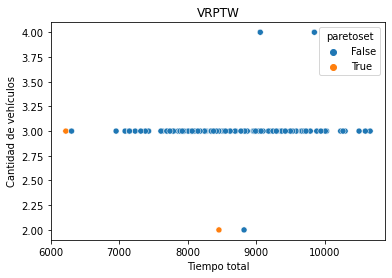

In [229]:
graficar(fitness)

In [ ]:
for gen in range(generaciones):
    descendientes = seleccionar(poblacion)
    for hijo1, hijo2 in zip(descendientes[::2], descendientes[1::2]):
        if random.random() < c_pbb:
            crossover(hijo1, hijo2)
    for mutante in descendientes:
        if random.random() < m_pbb:
            mutar(mutante)
    poblacion[:] = descendientes